In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


Optimized Portfolio Percentiles (5-25-50-75-95): [ 70394.54296395  91837.42237444 110287.85656619 132011.24814483
 174200.57800682]
Custom Portfolio Percentiles (5-25-50-75-95): [ 63899.95674278  79654.54771977  91983.12788097 106804.75006021
 132867.96939108]


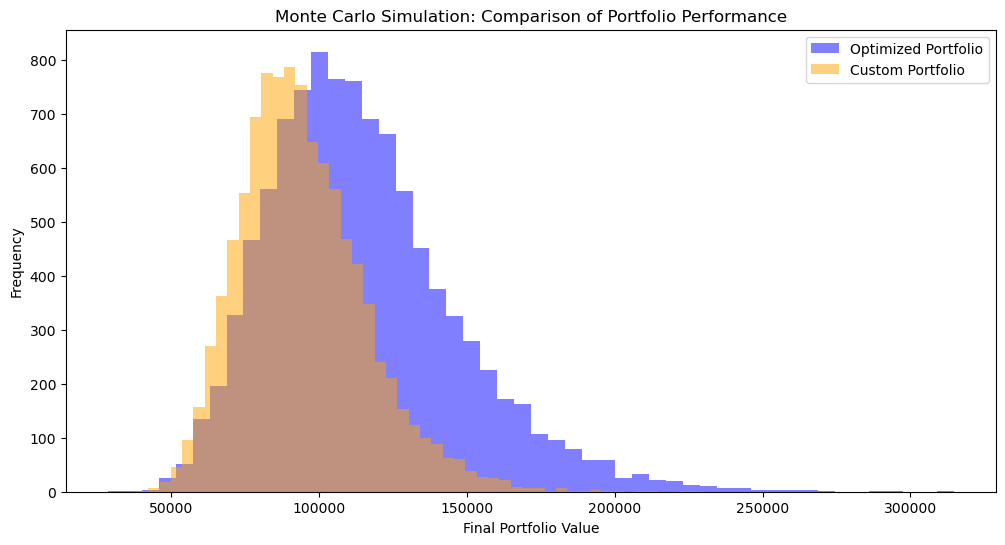

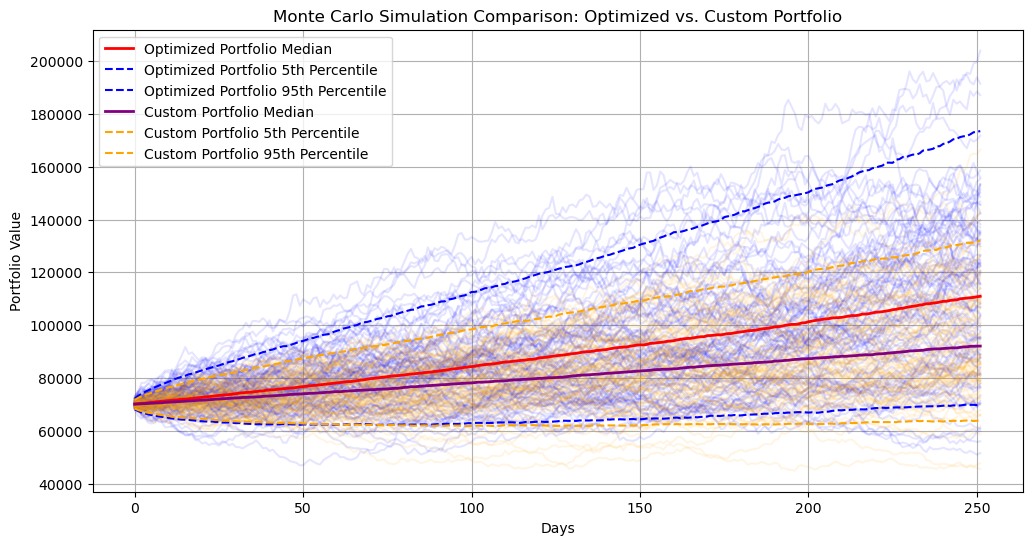

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caricamento e pre-elaborazione dei dati storici
file_path = r'C:\Users\Mattia\Desktop\Returns.xlsx'  # Aggiorna con il percorso del file
data_foglio1 = pd.read_excel(file_path, sheet_name='Foglio1', engine='openpyxl')

# Imposta Date come indice e converte i dati in valori numerici
data_foglio1.set_index('Date', inplace=True)
returns_data = data_foglio1.apply(pd.to_numeric, errors='coerce')
returns_data = returns_data.replace([np.inf, -np.inf], np.nan).dropna().astype(float)

# Calcolo dei rendimenti e della volatilità annualizzati
geometric_mean_daily = (1 + returns_data).prod() ** (1 / len(returns_data)) - 1
annual_geometric_mean = (1 + geometric_mean_daily) ** 252 - 1
annual_std_dev = returns_data.std() * np.sqrt(252)
cov_matrix = returns_data.cov() * 252

# Simulazione della frontiera efficiente
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

# Tasso privo di rischio
risk_free_rate = 0.042
np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.random(len(annual_geometric_mean))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.dot(weights, annual_geometric_mean)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0, i] = portfolio_stddev
    results[1, i] = portfolio_return
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_stddev

# Identificazione del portafoglio ottimizzato
optimal_weights = weights_record[np.argmax(results[2])]

# Simulazione Monte Carlo per il portafoglio a massima efficienza ottimizzato
initial_investment = 70000
num_simulations = 10000
time_horizon = 252  # giorni di trading in un anno

# Funzione per simulare il valore finale di un portafoglio
def monte_carlo_simulation(weights, annual_geometric_mean, cov_matrix, initial_investment, num_simulations, time_horizon):
    portfolio_simulation = []
    for _ in range(num_simulations):
        simulated_returns = np.random.normal(
            np.dot(weights, annual_geometric_mean) / time_horizon,
            np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) / time_horizon),
            time_horizon
        )
        portfolio_values = initial_investment * np.cumprod(1 + simulated_returns)
        portfolio_simulation.append(portfolio_values[-1])
    return portfolio_simulation

# Simulazione per il portafoglio ottimizzato
optimized_simulation = monte_carlo_simulation(optimal_weights, annual_geometric_mean, cov_matrix, initial_investment, num_simulations, time_horizon)

custom_weights = np.array([0.2881, 0.3237, 0.1025, 0.1589, 0.1135, 0.0133])

# Simulazione per il portafoglio non ottimizzato
custom_portfolio_simulation = monte_carlo_simulation(custom_weights, annual_geometric_mean, cov_matrix, initial_investment, num_simulations, time_horizon)

# Confronto dei percentili tra i due portafogli
optimized_percentiles = np.percentile(optimized_simulation, [5, 25, 50, 75, 95])
custom_portfolio_percentiles = np.percentile(custom_portfolio_simulation, [5, 25, 50, 75, 95])

print("Optimized Portfolio Percentiles (5-25-50-75-95):", optimized_percentiles)
print("Custom Portfolio Percentiles (5-25-50-75-95):", custom_portfolio_percentiles)

# Grafico dei risultati della simulazione
plt.figure(figsize=(12, 6))
plt.hist(optimized_simulation, bins=50, alpha=0.5, label='Optimized Portfolio', color='blue')
plt.hist(custom_portfolio_simulation, bins=50, alpha=0.5, label='Custom Portfolio', color='orange')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation: Comparison of Portfolio Performance')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# Grafico Montecarlo Simulation portafoglio ottimizzato 
for i in range(100):
    simulated_returns_optimized = np.random.normal(
        np.dot(optimal_weights, annual_geometric_mean) / time_horizon,
        np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)) / time_horizon),
        time_horizon
    )
    portfolio_values_optimized = initial_investment * np.cumprod(1 + simulated_returns_optimized)
    plt.plot(portfolio_values_optimized, color='blue', alpha=0.1)

# Grafico Montecarlo Simulation portafoglio non ottimizzato
for i in range(100):
    simulated_returns_custom = np.random.normal(
        np.dot(custom_weights, annual_geometric_mean) / time_horizon,
        np.sqrt(np.dot(custom_weights.T, np.dot(cov_matrix, custom_weights)) / time_horizon),
        time_horizon
    )
    portfolio_values_custom = initial_investment * np.cumprod(1 + simulated_returns_custom)
    plt.plot(portfolio_values_custom, color='orange', alpha=0.1)

# Calcolo mediana e percentili per ogni giorno durante la simulazione, portafoglio Ottimizzato
simulation_array_optimized = np.array([initial_investment * np.cumprod(1 + np.random.normal(
    np.dot(optimal_weights, annual_geometric_mean) / time_horizon,
    np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)) / time_horizon),
    time_horizon)) for _ in range(num_simulations)])

median_optimized = np.median(simulation_array_optimized, axis=0)
percentiles_5_optimized = np.percentile(simulation_array_optimized, 5, axis=0)
percentiles_95_optimized = np.percentile(simulation_array_optimized, 95, axis=0)

# Calcolo mediana e percentili per ogni giorno durante la simulazione, portafoglio non Ottimizzato
simulation_array_custom = np.array([initial_investment * np.cumprod(1 + np.random.normal(
    np.dot(custom_weights, annual_geometric_mean) / time_horizon,
    np.sqrt(np.dot(custom_weights.T, np.dot(cov_matrix, custom_weights)) / time_horizon),
    time_horizon)) for _ in range(num_simulations)])

median_custom = np.median(simulation_array_custom, axis=0)
percentiles_5_custom = np.percentile(simulation_array_custom, 5, axis=0)
percentiles_95_custom = np.percentile(simulation_array_custom, 95, axis=0)


plt.plot(median_optimized, color='red', label='Optimized Portfolio Median', linewidth=2)
plt.plot(percentiles_5_optimized, color='blue', linestyle='--', label='Optimized Portfolio 5th Percentile', linewidth=1.5)
plt.plot(percentiles_95_optimized, color='blue', linestyle='--', label='Optimized Portfolio 95th Percentile', linewidth=1.5)


plt.plot(median_custom, color='purple', label='Custom Portfolio Median', linewidth=2)
plt.plot(percentiles_5_custom, color='orange', linestyle='--', label='Custom Portfolio 5th Percentile', linewidth=1.5)
plt.plot(percentiles_95_custom, color='orange', linestyle='--', label='Custom Portfolio 95th Percentile', linewidth=1.5)


plt.title("Monte Carlo Simulation Comparison: Optimized vs. Custom Portfolio")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


